In [1]:
import seaborn as sns
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random


# Load the dataset
dataset = load_dataset('bigscience/P3', 'cos_e_v1.11_aligned_with_common_sense')
train_dataset = dataset['train']

# Initialize the tokenizer and models (one or continuous prompting and other for projected prompting
model_projected = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_projected.to(device)

# Define the prompt basis
prompt_list = [
    "Generate a flowchart to visually represent the logic needed to answer the question",
    "Write pseudocode for an algorithm that could determine the answer", 
    "Imagine you are explaining the answer to a 5-year-old. Use simple words and analogies.",
    "Summarize the key insights needed to answer in a short poem",
    "Draw a concept map connecting all ideas relevant to the question",
    "List assumptions you must make to provide an answer. What if those assumptions were different?",
    "Compare and contrast multiple ways to approach the question", 
    "Translate the essence of the question into visual art and describe your interpretation",
    "Act out an exaggerated skit to depict the logic behind the answer",
    "Design a decision tree leading to the final answer",
    "Develop a graphic organizer highlighting relationships between key ideas",
    "Frame the question from different philosophical perspectives and give each perspective's answer", 
    "Outline an experiment that could empirically validate the answer",
    "Write a song conveying the concepts needed to respond accurately",
    "Create a metaphor relating the question to a seemingly unrelated domain",
    "Prototype a computer program to compute the answer algorithmically"
]

print(f'tokenizing prompts')
print(f'prompt list length {len(prompt_list)}')

basis = tokenizer(prompt_list, padding=True, truncation=True, return_tensors='pt').to(device)
basis = model_projected.model.shared(basis.input_ids)

def tokenize_function(example):
    return tokenizer(example['inputs_pretokenized'], truncation=True, padding='max_length')

# Apply the function to the dataset
print('tokenzing dataset')
dataset = dataset.map(tokenize_function, batched=True)
train_dataset = dataset['train']
validation_dataset = dataset['validation']

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the weight prediction model
class LearnWeights(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.5):
        super(LearnWeights, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.layer3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = F.relu(self.layer3(x))
        x = self.dropout3(x)
        x = self.output_layer(x)
        x = x.mean(dim=1, keepdim=True)  # Compute the mean across the token dimension and batch dimension
        return x.squeeze(1).mean(dim=0)


# Define the projected prompt
input_dim = 1024

output_dim = len(prompt_list)
learn_weights = LearnWeights(input_dim, output_dim).to(device)
optimizer_projected = AdamW(learn_weights.parameters())

# Training parameters
epochs = 5
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/ppxscal/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tokenizing prompts
prompt list length 16
tokenzing dataset


Map: 100%|██████████| 1221/1221 [00:00<00:00, 1523.76 examples/s]
/home/ppxscal/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training...
Epoch 1/20, Batch 0/9741
Batch Indices: [3440, 3441]
Loss: 6.702618598937988

Epoch 1/20, Batch 200/9741
Batch Indices: [3566, 3567]
Loss: 9.460693359375

Epoch 1/20, Batch 400/9741
Batch Indices: [2684, 2685]
Loss: 10.007939338684082

Epoch 1/20, Batch 600/9741
Batch Indices: [14752, 14753]
Loss: 8.481191635131836

Epoch 1/20, Batch 800/9741
Batch Indices: [2102, 2103]
Loss: 7.397567272186279

Epoch 1/20, Batch 1000/9741
Batch Indices: [4602, 4603]
Loss: 10.163780212402344

Epoch 1/20, Batch 1200/9741
Batch Indices: [13738, 13739]
Loss: 8.086274147033691

Epoch 1/20, Batch 1400/9741
Batch Indices: [294, 295]
Loss: 9.559062004089355

Epoch 1/20, Batch 1600/9741
Batch Indices: [17018, 17019]
Loss: 7.718416213989258

Epoch 1/20, Batch 1800/9741
Batch Indices: [8810, 8811]
Loss: 6.712094306945801

Epoch 1/20, Batch 2000/9741
Batch Indices: [16220, 16221]
Loss: 6.044028282165527

Epoch 1/20, Batch 2200/9741
Batch Indices: [13752, 13753]
Loss: 7.816109657287598

Epoch 1/20, Batc

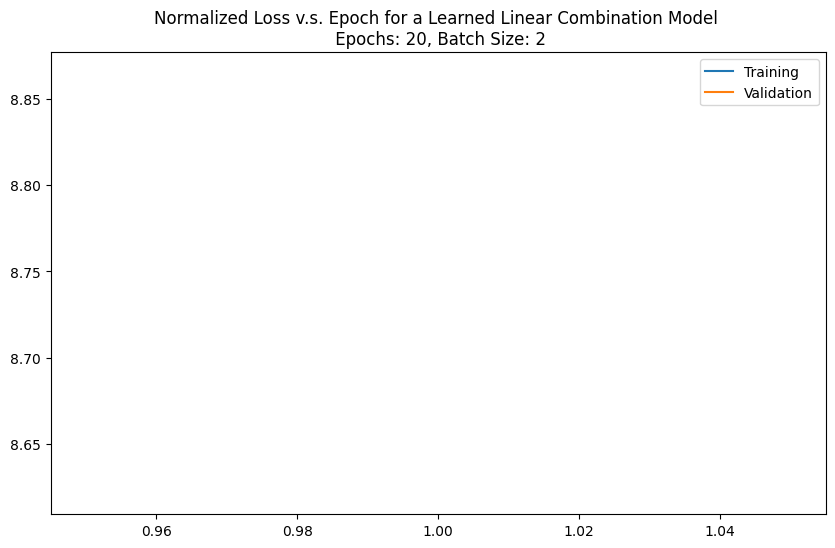

Epoch 2/20, Batch 0/9741
Batch Indices: [3958, 3959]
Loss: 8.20815658569336

Epoch 2/20, Batch 200/9741
Batch Indices: [8796, 8797]
Loss: 9.050583839416504

Epoch 2/20, Batch 400/9741
Batch Indices: [17428, 17429]
Loss: 11.082938194274902

Epoch 2/20, Batch 600/9741
Batch Indices: [4096, 4097]
Loss: 5.816778659820557

Epoch 2/20, Batch 800/9741
Batch Indices: [15022, 15023]
Loss: 12.665983200073242

Epoch 2/20, Batch 1000/9741
Batch Indices: [8084, 8085]
Loss: 8.20185375213623

Epoch 2/20, Batch 1200/9741
Batch Indices: [11668, 11669]
Loss: 10.20007038116455

Epoch 2/20, Batch 1400/9741
Batch Indices: [294, 295]
Loss: 9.183801651000977

Epoch 2/20, Batch 1600/9741
Batch Indices: [8924, 8925]
Loss: 9.849427223205566

Epoch 2/20, Batch 1800/9741
Batch Indices: [13976, 13977]
Loss: 7.58351469039917

Epoch 2/20, Batch 2000/9741
Batch Indices: [11036, 11037]
Loss: 10.176219940185547

Epoch 2/20, Batch 2200/9741
Batch Indices: [11870, 11871]
Loss: 9.46969985961914

Epoch 2/20, Batch 2400/974

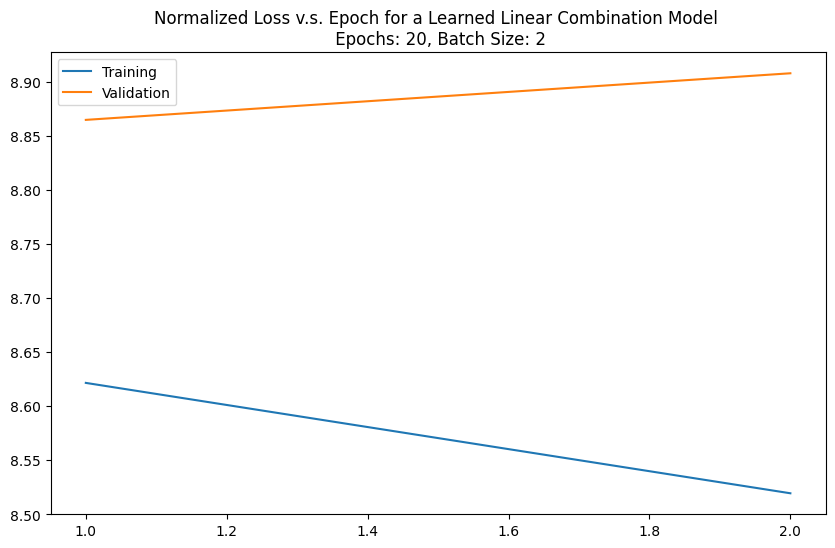

Epoch 3/20, Batch 0/9741
Batch Indices: [13518, 13519]
Loss: 7.9438652992248535

Epoch 3/20, Batch 200/9741
Batch Indices: [832, 833]
Loss: 9.302335739135742

Epoch 3/20, Batch 400/9741
Batch Indices: [8154, 8155]
Loss: 7.969502925872803

Epoch 3/20, Batch 600/9741
Batch Indices: [16752, 16753]
Loss: 8.187982559204102

Epoch 3/20, Batch 800/9741
Batch Indices: [17842, 17843]
Loss: 8.702013969421387

Epoch 3/20, Batch 1000/9741
Batch Indices: [7314, 7315]
Loss: 9.447330474853516

Epoch 3/20, Batch 1200/9741
Batch Indices: [13144, 13145]
Loss: 9.174036026000977

Epoch 3/20, Batch 1400/9741
Batch Indices: [14224, 14225]
Loss: 10.425342559814453

Epoch 3/20, Batch 1600/9741
Batch Indices: [10908, 10909]
Loss: 8.386869430541992

Epoch 3/20, Batch 1800/9741
Batch Indices: [16166, 16167]
Loss: 8.387861251831055

Epoch 3/20, Batch 2000/9741
Batch Indices: [6766, 6767]
Loss: 8.212048530578613

Epoch 3/20, Batch 2200/9741
Batch Indices: [5524, 5525]
Loss: 8.412836074829102

Epoch 3/20, Batch 240

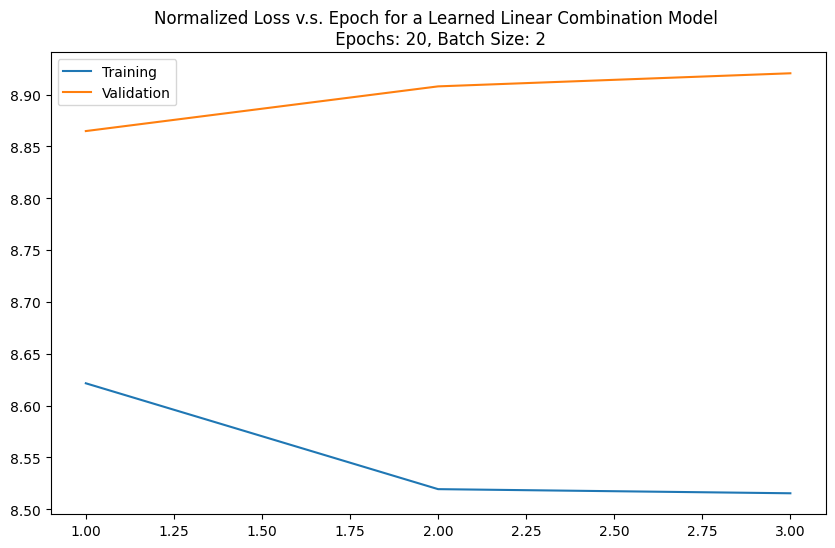

Epoch 4/20, Batch 0/9741
Batch Indices: [8896, 8897]
Loss: 10.24188232421875

Epoch 4/20, Batch 200/9741
Batch Indices: [2916, 2917]
Loss: 9.151488304138184

Epoch 4/20, Batch 400/9741
Batch Indices: [13434, 13435]
Loss: 8.763792991638184

Epoch 4/20, Batch 600/9741
Batch Indices: [8526, 8527]
Loss: 8.70261001586914

Epoch 4/20, Batch 800/9741
Batch Indices: [13682, 13683]
Loss: 8.89207935333252

Epoch 4/20, Batch 1000/9741
Batch Indices: [3144, 3145]
Loss: 9.060794830322266

Epoch 4/20, Batch 1200/9741
Batch Indices: [4614, 4615]
Loss: 7.398360252380371

Epoch 4/20, Batch 1400/9741
Batch Indices: [4824, 4825]
Loss: 8.254924774169922

Epoch 4/20, Batch 1600/9741
Batch Indices: [16540, 16541]
Loss: 7.946138381958008

Epoch 4/20, Batch 1800/9741
Batch Indices: [13806, 13807]
Loss: 8.31550121307373

Epoch 4/20, Batch 2000/9741
Batch Indices: [15840, 15841]
Loss: 10.173144340515137

Epoch 4/20, Batch 2200/9741
Batch Indices: [2796, 2797]
Loss: 9.467436790466309

Epoch 4/20, Batch 2400/9741

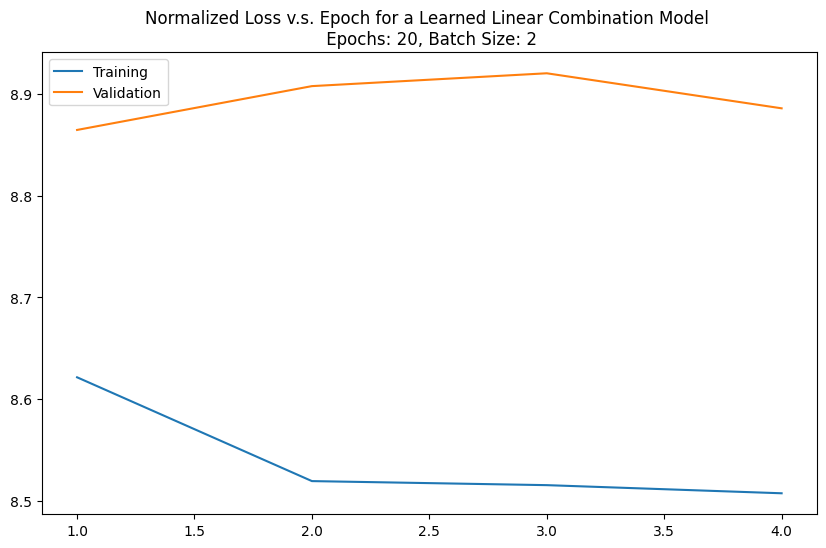

Epoch 5/20, Batch 0/9741
Batch Indices: [10046, 10047]
Loss: 8.023778915405273

Epoch 5/20, Batch 200/9741
Batch Indices: [13350, 13351]
Loss: 9.516352653503418

Epoch 5/20, Batch 400/9741
Batch Indices: [3652, 3653]
Loss: 8.719793319702148

Epoch 5/20, Batch 600/9741
Batch Indices: [6924, 6925]
Loss: 5.379830837249756

Epoch 5/20, Batch 800/9741
Batch Indices: [15260, 15261]
Loss: 7.31938362121582

Epoch 5/20, Batch 1000/9741
Batch Indices: [970, 971]
Loss: 8.3928861618042

Epoch 5/20, Batch 1200/9741
Batch Indices: [10812, 10813]
Loss: 8.364216804504395

Epoch 5/20, Batch 1400/9741
Batch Indices: [13184, 13185]
Loss: 8.715412139892578

Epoch 5/20, Batch 1600/9741
Batch Indices: [13052, 13053]
Loss: 8.685111045837402

Epoch 5/20, Batch 1800/9741
Batch Indices: [1066, 1067]
Loss: 9.334985733032227

Epoch 5/20, Batch 2000/9741
Batch Indices: [4646, 4647]
Loss: 7.028167724609375

Epoch 5/20, Batch 2200/9741
Batch Indices: [1684, 1685]
Loss: 8.847587585449219

Epoch 5/20, Batch 2400/9741


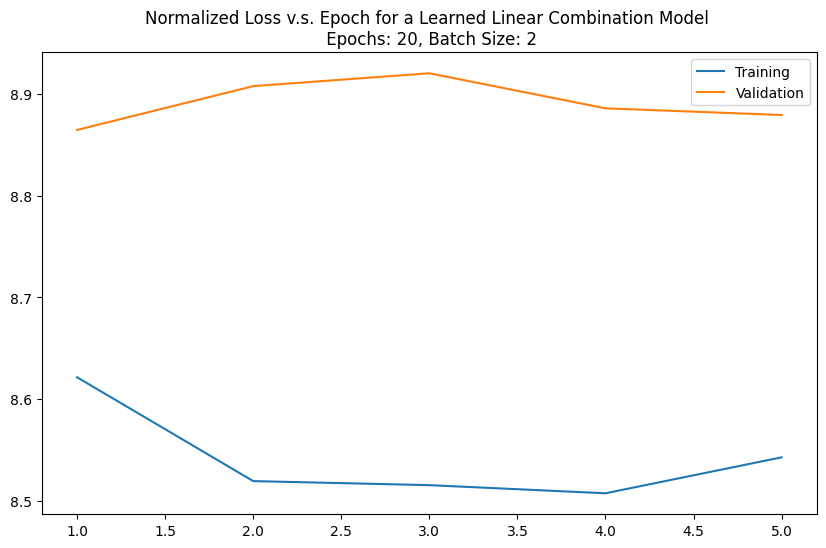

Epoch 6/20, Batch 0/9741
Batch Indices: [9492, 9493]
Loss: 8.37763786315918

Epoch 6/20, Batch 200/9741
Batch Indices: [9876, 9877]
Loss: 8.437468528747559

Epoch 6/20, Batch 400/9741
Batch Indices: [9808, 9809]
Loss: 9.672811508178711

Epoch 6/20, Batch 600/9741
Batch Indices: [18256, 18257]
Loss: 7.676296710968018

Epoch 6/20, Batch 800/9741
Batch Indices: [9600, 9601]
Loss: 8.656294822692871

Epoch 6/20, Batch 1000/9741
Batch Indices: [7264, 7265]
Loss: 9.18937873840332

Epoch 6/20, Batch 1200/9741
Batch Indices: [17764, 17765]
Loss: 10.298561096191406

Epoch 6/20, Batch 1400/9741
Batch Indices: [8944, 8945]
Loss: 8.942082405090332

Epoch 6/20, Batch 1600/9741
Batch Indices: [3440, 3441]
Loss: 7.298919677734375

Epoch 6/20, Batch 1800/9741
Batch Indices: [18198, 18199]
Loss: 7.888627529144287

Epoch 6/20, Batch 2000/9741
Batch Indices: [10040, 10041]
Loss: 9.34226131439209

Epoch 6/20, Batch 2200/9741
Batch Indices: [15486, 15487]
Loss: 7.170767307281494

Epoch 6/20, Batch 2400/9741

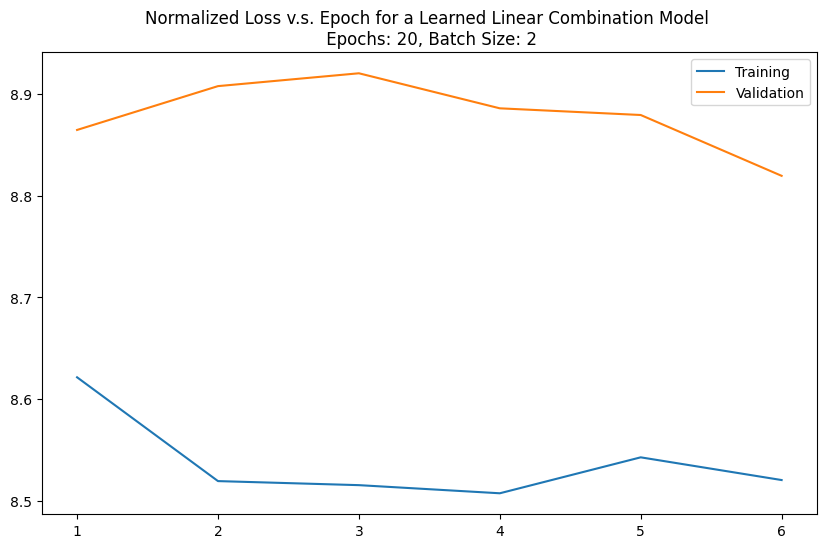

Epoch 7/20, Batch 0/9741
Batch Indices: [4594, 4595]
Loss: 9.194883346557617

Epoch 7/20, Batch 200/9741
Batch Indices: [19158, 19159]
Loss: 8.493245124816895

Epoch 7/20, Batch 400/9741
Batch Indices: [1836, 1837]
Loss: 8.784607887268066

Epoch 7/20, Batch 600/9741
Batch Indices: [15732, 15733]
Loss: 8.630078315734863

Epoch 7/20, Batch 800/9741
Batch Indices: [3976, 3977]
Loss: 8.931785583496094

Epoch 7/20, Batch 1000/9741
Batch Indices: [9240, 9241]
Loss: 9.53087043762207

Epoch 7/20, Batch 1200/9741
Batch Indices: [12314, 12315]
Loss: 8.495279312133789

Epoch 7/20, Batch 1400/9741
Batch Indices: [18416, 18417]
Loss: 9.158951759338379

Epoch 7/20, Batch 1600/9741
Batch Indices: [7784, 7785]
Loss: 8.790182113647461

Epoch 7/20, Batch 1800/9741
Batch Indices: [1518, 1519]
Loss: 10.804210662841797

Epoch 7/20, Batch 2000/9741
Batch Indices: [4810, 4811]
Loss: 9.335280418395996

Epoch 7/20, Batch 2200/9741
Batch Indices: [4148, 4149]
Loss: 7.659059524536133

Epoch 7/20, Batch 2400/9741

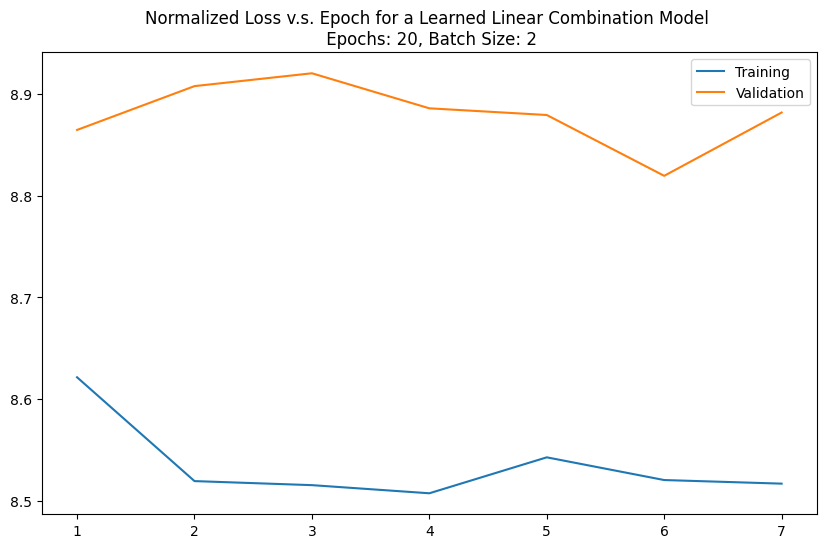

Epoch 8/20, Batch 0/9741
Batch Indices: [11236, 11237]
Loss: 7.693759918212891

Epoch 8/20, Batch 200/9741
Batch Indices: [10416, 10417]
Loss: 9.291534423828125

Epoch 8/20, Batch 400/9741
Batch Indices: [15020, 15021]
Loss: 10.56091022491455

Epoch 8/20, Batch 600/9741
Batch Indices: [15218, 15219]
Loss: 10.424538612365723

Epoch 8/20, Batch 800/9741
Batch Indices: [3130, 3131]
Loss: 10.295987129211426

Epoch 8/20, Batch 1000/9741
Batch Indices: [11212, 11213]
Loss: 7.837748050689697

Epoch 8/20, Batch 1200/9741
Batch Indices: [19130, 19131]
Loss: 8.36108684539795

Epoch 8/20, Batch 1400/9741
Batch Indices: [9056, 9057]
Loss: 7.428790092468262

Epoch 8/20, Batch 1600/9741
Batch Indices: [3390, 3391]
Loss: 8.53242301940918

Epoch 8/20, Batch 1800/9741
Batch Indices: [10896, 10897]
Loss: 7.73628044128418

Epoch 8/20, Batch 2000/9741
Batch Indices: [5450, 5451]
Loss: 8.08524227142334

Epoch 8/20, Batch 2200/9741
Batch Indices: [16982, 16983]
Loss: 9.955991744995117

Epoch 8/20, Batch 240

In [6]:
from torch.utils.data import DataLoader

# Training parameters
epochs = 20
batch_size = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Training...')

# Training loop
projected_losses = []
validation_losses = []

shapes = []


for epoch in range(epochs):
    epoch_loss_projected = 0
    epoch_loss_validation = 0
    for _ in range(0, len(train_dataset), batch_size):
        i = random.randint(0, len(train_dataset) - batch_size + 1 )
        batch = train_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 100 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)


        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')


        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)

        # Pass the combined embeddings through the model
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)
 

        loss_projected = outputs_projected.loss
        epoch_loss_projected += loss_projected.item()
        

        optimizer_projected.zero_grad()
        loss_projected.backward(retain_graph=True)
        optimizer_projected.step()

        #print(f'complete from this epoch {i}/{len(train_dataset)}', end='')
        if _ % 200 == 0:
          print(f'Epoch {epoch+1}/{epochs}, Batch {_}/{len(train_dataset)}')
          print(f'Batch Indices: {[i + k for k in range(i, i+batch_size)]}')
          print(f'Loss: {loss_projected.item()}')
          print()

    print('Validating Epoch...')

    for _ in range(0, len(validation_dataset), batch_size):
        i = random.randint(0, len(validation_dataset) - batch_size + 1 )
        batch = validation_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 100 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)

        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')

        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)

        loss_validation = outputs_projected.loss
        epoch_loss_validation += loss_validation.item()

    epoch_loss_projected /= (len(list(range(0, len(train_dataset), batch_size))))
    epoch_loss_validation /= (len(list(range(0, len(validation_dataset), batch_size))) - 1)

    print(f'Epoch Validation Loss: {epoch_loss_validation} \n', end='')
    print()

    projected_losses.append(epoch_loss_projected)
    validation_losses.append(epoch_loss_validation)

    # Create a DataFrame with the loss values
    n = len(projected_losses)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n + 1), projected_losses, label='Training')
    plt.plot(range(1, n + 1), validation_losses, label='Validation')
    
    plt.title(f'Normalized Loss v.s. Epoch for a Learned Linear Combination Model \n Epochs: {epochs}, Batch Size: {batch_size}')
    plt.legend()

    # Save the plot as a png file
    print(f'Saveing figure...')
    plt.savefig(f'loss_plot_epoch_{epoch+1}.png')
    plt.show()
